In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.optim as optim

import src.preprocessing as pre
import src.metrics as metrics
import src.models as models

from typing import Dict, Iterable, Tuple, Optional

np.set_printoptions(suppress=True, linewidth=120)
plt.rcParams["figure.dpi"] = 120
RNG_SEED = 0


In [24]:
X, y = pre.load_faces_csv("data/caras.csv", label_col="person_id")
print("X:", X.shape, " | y:", y.shape, " | #clases:", np.unique(y).size)




X: (400, 4096)  | y: (400,)  | #clases: 40


1. Inspección de los datos

1.1 Primera Observacion de los Datos

Comienzo por observar 15 imagenes seleccionadas de manera aleatoria.

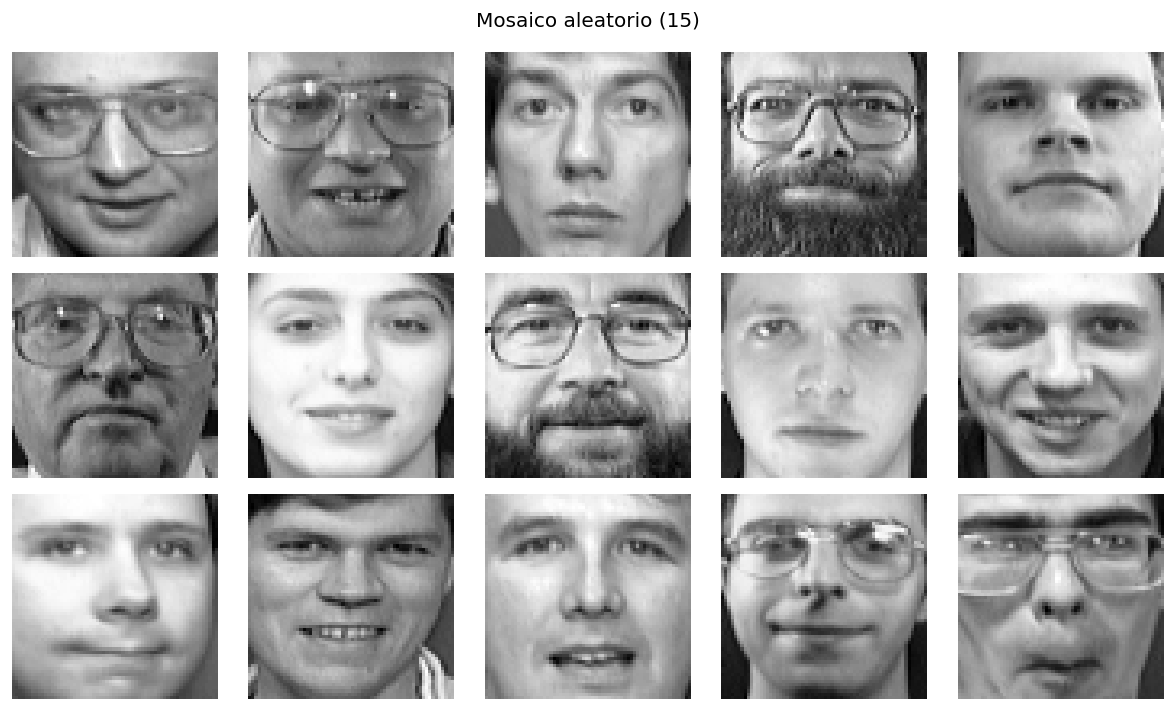

In [25]:
idxs = np.random.choice(len(X), size=15, replace=False)

def plot_images(X: np.ndarray, idxs: np.ndarray, img_shape: Tuple[int, int], suptitle: Optional[str] = None):
    n = len(idxs)
    n_cols = 5
    n_rows = int(np.ceil(n / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    for i, ax in enumerate(axes.flat):
        if i < n:
            img = X[idxs[i]].reshape(img_shape)
            ax.imshow(img, cmap="gray")
            ax.axis("off")
        else:
            ax.axis("off")
    if suptitle:
        plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()
     

plot_images(X, idxs, img_shape=(64, 64), suptitle="Mosaico aleatorio (15)");

1.2 Analisis Exploratorio de la Distribución de Clases

Analizo la cantidad de muestras por cada clase y lo grafico

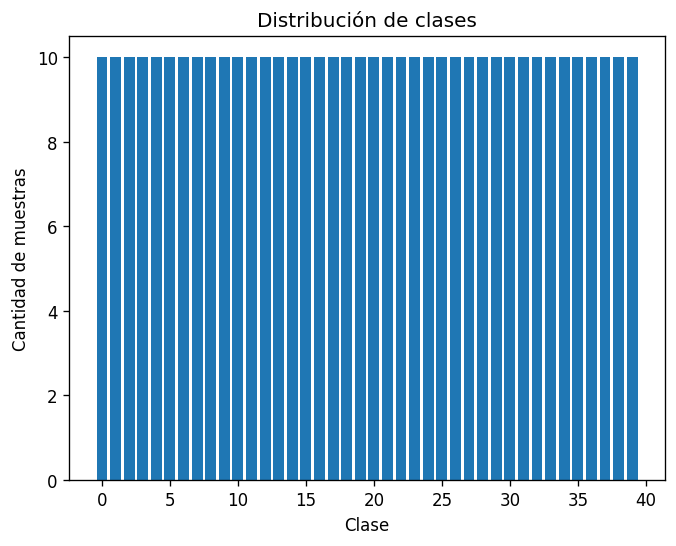

In [26]:
# distribución de clases
vals, counts = np.unique(y, return_counts=True)
# grafico la distribucion de las clases
plt.bar(vals, counts)
plt.xlabel("Clase")
plt.ylabel("Cantidad de muestras")
plt.title("Distribución de clases")
plt.show()

Las clases estan perfectamente balanceadas con igual cantidad de muestras por clase. Por el momento no aplico ningun cambio en el dataset.

Grafico muestras agrupadas por clase, para 5 clases.

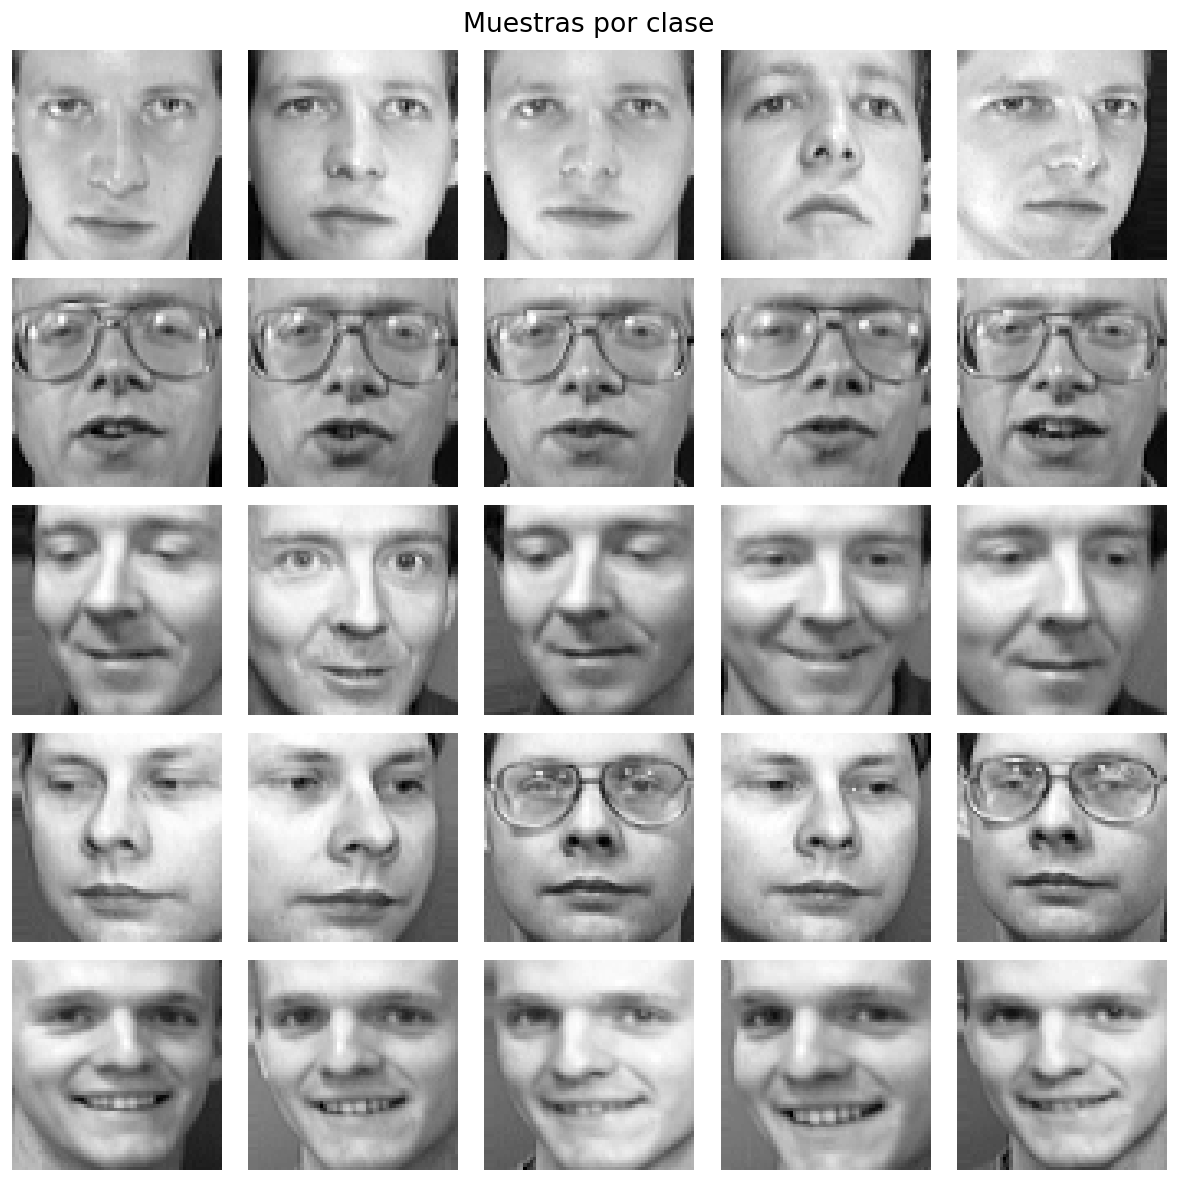

In [27]:
# distribución de clases
vals, counts = np.unique(y, return_counts=True)

def plot_by_class(X: np.ndarray, y: np.ndarray, classes: Iterable[int], per_class: int = 10):
    n_classes = len(classes)
    fig, axes = plt.subplots(n_classes, per_class, figsize=(per_class * 2, n_classes * 2))
    for i, cls in enumerate(classes):
        cls_idxs = np.where(y == cls)[0]
        sel_idxs = np.random.choice(cls_idxs, size=per_class, replace=False)
        for j, idx in enumerate(sel_idxs):
            img = X[idx].reshape(64, 64)
            axes[i, j].imshow(img, cmap="gray")
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_ylabel(f"Clase {cls}", fontsize=12)
    plt.suptitle("Muestras por clase", fontsize=16)
    plt.tight_layout()
    plt.show()

# muestras por 5 clases (elige automáticamente las 5 más frecuentes)
top5 = vals[np.argsort(-counts)[:5]]
plot_by_class(X, y, top5, per_class=5)

1.3 Split de los Datos

Separo los datos en Train (80%) y Validation (20%)

In [28]:
(Xtr, ytr), (Xval, yval) = pre.stratified_split(X, y, test_size=0.2, random_state=RNG_SEED)
print("train:", Xtr.shape, "clases:", np.unique(ytr).size, "| test:", Xval.shape, "clases:", np.unique(yval).size)

train: (320, 4096) clases: 40 | test: (80, 4096) clases: 40


Estandarización de los datos

In [29]:
st = pre.standardize_fit(Xtr)
Xtr_std = pre.standardize_transform(Xtr, st)
Xval_std = pre.standardize_transform(Xval, st)


2. Reducción de dimensionalidad

2.1 Aplicación de PCA sobre los datos estandarizados

In [30]:
pca = pre.pca_fit(Xtr_std) 

Grafico de la varianza explicada acumulada en función del numero de componentes

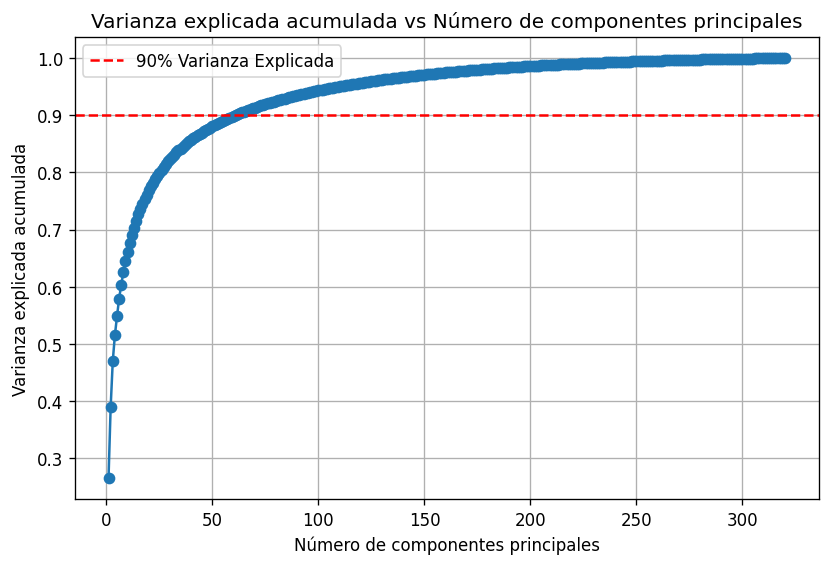

In [31]:
def explained_variance_plot(pca: Dict[str, np.ndarray]):
    cum_explained_ratio = pca["cum_explained_ratio"]
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cum_explained_ratio) + 1), cum_explained_ratio, marker='o')
    plt.xlabel("Número de componentes principales")
    plt.ylabel("Varianza explicada acumulada")
    plt.title("Varianza explicada acumulada vs Número de componentes principales")
    plt.grid()
    plt.axhline(y=0.90, color='r', linestyle='--', label='90% Varianza Explicada')
    plt.legend()
    plt.show()

explained_variance_plot(pca)

Me quedo con el número de componentes que me aseguren explicar el 90 % de la
varianza de los dato denotada por la linea punteada del grafico anterior

In [44]:
# ===== Selección de k SOLO con TRAIN, luego aplicamos a VALID =====
# Opciones: "var90" (umbral de varianza en TRAIN) o "elbow_train" (codo con MSE TRAIN)
METHOD  = "var90"       # o "elbow_train"
VAR_THR = 0.90          # umbral de varianza para METHOD="var90"

# MSE de reconstrucción usando k PCs (SOLO TRAIN)
def pca_train_mse_for_k(k: int) -> float:
    Ztr   = pre.pca_transform(Xtr_std, pca, k)
    Xtr_r = pre.pca_inverse(Ztr, pca, k)
    return float(((Xtr_std - Xtr_r) ** 2).mean())

# k por varianza explicada en TRAIN
k90 = int(np.searchsorted(pca["cum_explained_ratio"], VAR_THR) + 1)

if METHOD == "var90":
    k_pca = max(2, k90)
    print(f"[TRAIN-only] k_pca por varianza ≥ {int(VAR_THR*100)}% → k={k_pca}")

elif METHOD == "elbow_train":
    # barrido alrededor de k90 para no alargar mucho
    k_min = max(2, k90 - 20)
    k_max = min(Xtr_std.shape[1], k90 + 20)
    ks    = np.arange(k_min, k_max + 1, dtype=int)
    mse_tr = np.array([pca_train_mse_for_k(k) for k in ks])

    # Elegimos k por codo en TRAIN (ganancias decrecientes sobre MSE)
    k_rel, k_dd, diag = metrics.select_k_by_elbow(mse_tr, ks, rel_thresh=0.05)
    k_pca = int(min(k_rel, k_dd))  # conservador
    print(f"[TRAIN-only] k_pca por codo → umbral={k_rel}, 2da dif={k_dd} → k={k_pca}")

    # (Opcional) gráfico rápido
    fig, ax = plt.subplots(1,2, figsize=(9,3))
    ax[0].plot(ks, mse_tr, marker="o"); ax[0].set_title("MSE recon · TRAIN vs k")
    ax[0].set_xlabel("k"); ax[0].grid(True, alpha=0.3)
    gains = metrics.elbow_gains(mse_tr)
    ax[1].plot(ks, gains, marker="o"); ax[1].set_title("Ganancia marginal (TRAIN)")
    ax[1].set_xlabel("k"); ax[1].grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

else:
    raise ValueError("METHOD debe ser 'var90' o 'elbow_train'.")

# Aplicamos la transformación elegida a TRAIN y VALID (usando el PCA ya ajustado en TRAIN)
Ztr_pca  = pre.pca_transform(Xtr_std,  pca, k=k_pca)
Zval_pca = pre.pca_transform(Xval_std, pca, k=k_pca)

# Métrica informativa (MSE TRAIN) para el k elegido
mse_train_sel = pca_train_mse_for_k(k_pca)
print("Ztr_pca:", Ztr_pca.shape, "| Zval_pca:", Zval_pca.shape, "| MSE TRAIN (k seleccionado):", round(mse_train_sel, 6))


[TRAIN-only] k_pca por varianza ≥ 90% → k=61
Ztr_pca: (320, 61) | Zval_pca: (80, 61) | MSE TRAIN (k seleccionado): 0.099087


Para comparar los datos originales con la reduccion de dimensionalidad hecha con PCA grafico 10 imagenes

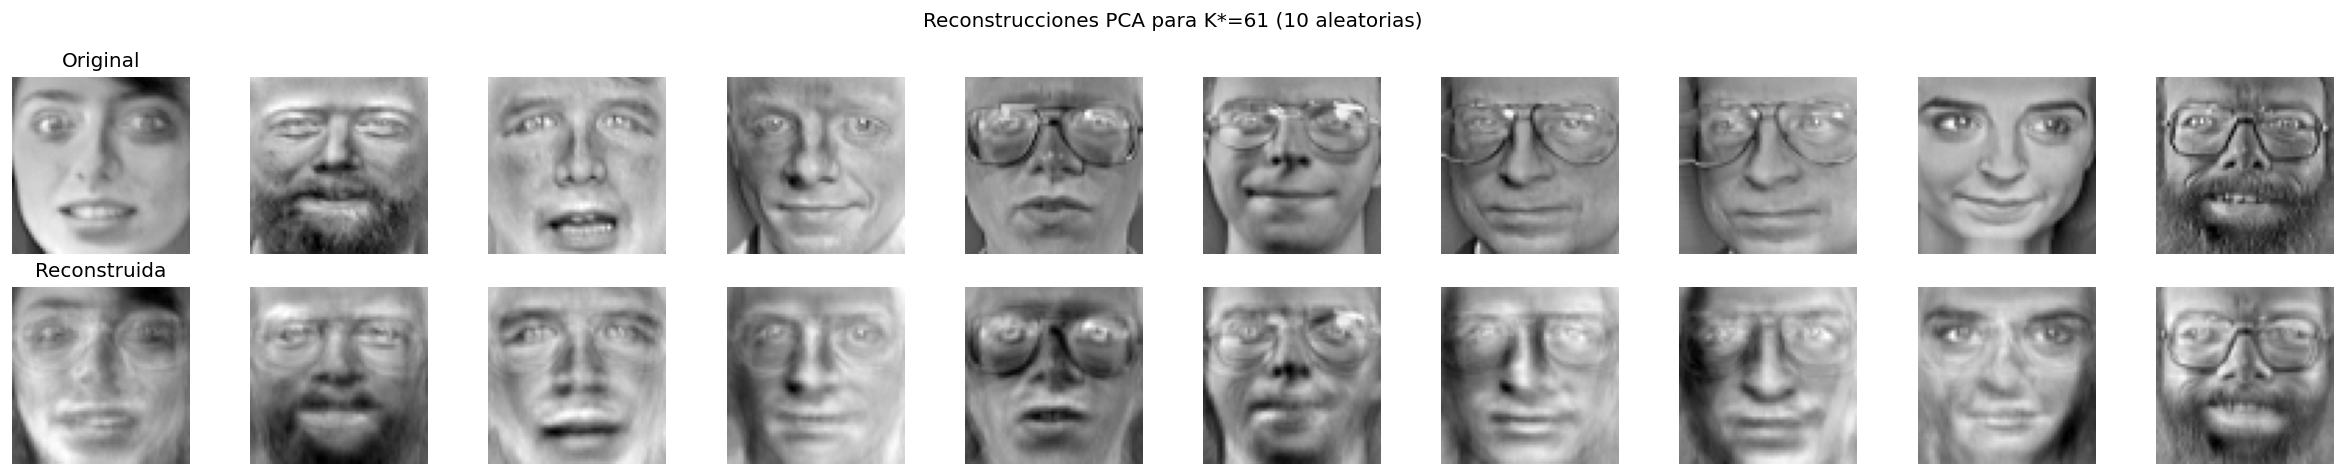

In [48]:
# Grafico 10 imagenes originales vs reconstruidas por PCA
def plot_reconstructions(X_orig: np.ndarray, X_rec: np.ndarray, idxs
                                : np.ndarray, img_shape: Tuple[int, int], suptitle: Optional[str] = None):
        n = len(idxs)
        fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))
        for i, ax in enumerate(axes.flat):
            if i < n:
                img = X_orig[idxs[i]].reshape(img_shape)
                ax.imshow(img, cmap="gray")
                ax.axis("off")
                if i == 0:
                    ax.set_title("Original", fontsize=12)
            else:
                img = X_rec[idxs[i - n]].reshape(img_shape)
                ax.imshow(img, cmap="gray")
                ax.axis("off")
                if i == n:
                    ax.set_title("Reconstruida", fontsize=12)
        if suptitle:
            plt.suptitle(suptitle)
        plt.tight_layout()
        plt.show()

Zval_pca = pre.pca_transform(Xval_std, pca, k=k_pca)
Xval_rec_pca = pre.pca_inverse(Zval_pca, pca, k=k_pca)
idxs = np.random.choice(len(Xval_std), size=10, replace=False)  

# Grafico las reconstrucciones PCA
plot_reconstructions(Xval_std, Xval_rec_pca, idxs, img_shape=(64, 64), suptitle=f"Reconstrucciones PCA para K*={k_pca} (10 aleatorias)")


Todas las reconstrucciones parecen bastante acertadas. Se eliminan posibles detalles innecesarios como algunos fondos

2.3 Aplicacion de AutoEncoder Deterministico

Para la implementacion del Autoencoder utilizo PyTorch

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Defino el modelo

In [35]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# ----- AE flexible -----
class AE(nn.Module):
    def __init__(self, D, k, width=512, depth=2, dropout=0.0):
        super().__init__()
        enc_layers = []
        in_dim = D
        for _ in range(depth):
            enc_layers += [nn.Linear(in_dim, width), nn.ReLU()]
            if dropout > 0: enc_layers += [nn.Dropout(dropout)]
            in_dim = width
        enc_layers += [nn.Linear(in_dim, k)]
        self.enc = nn.Sequential(*enc_layers)

        dec_layers = []
        in_dim = k
        for _ in range(depth):
            dec_layers += [nn.Linear(in_dim, width), nn.ReLU()]
            if dropout > 0: dec_layers += [nn.Dropout(dropout)]
            in_dim = width
        dec_layers += [nn.Linear(in_dim, D)]
        self.dec = nn.Sequential(*dec_layers)

    def forward(self, x):
        z  = self.enc(x)
        xr = self.dec(z)
        return xr, z

# ----- Entrenamiento con early stopping por MSE val -----
def train_ae(
    Xtr_std, Xval_std,
    k_lat,
    width=512, depth=2, dropout=0.0,
    lr=1e-3, weight_decay=1e-5, batch_size=256,
    epochs=200, patience=15,
    denoise_sigma=0.0,  # si >0, agrega ruido gaussiano al input de train
    seed=RNG_SEED
):
    torch.manual_seed(seed)
    D = Xtr_std.shape[1]
    model = AE(D, k_lat, width=width, depth=depth, dropout=dropout).to(device)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    tr_ds  = TensorDataset(torch.from_numpy(Xtr_std).float())
    val_ds = TensorDataset(torch.from_numpy(Xval_std).float())
    tr_dl  = DataLoader(tr_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

    best_val = np.inf
    best_state = None
    bad = 0
    hist = {"train": [], "val": []}

    for ep in range(1, epochs+1):
        # train
        model.train()
        ep_tr_loss = 0.0
        for (xb,) in tr_dl:
            xb = xb.to(device)
            if denoise_sigma > 0:
                noise = torch.randn_like(xb) * denoise_sigma
                x_in = xb + noise
            else:
                x_in = xb
            opt.zero_grad()
            xr, _ = model(x_in)
            loss = loss_fn(xr, xb)
            loss.backward()
            opt.step()
            ep_tr_loss += loss.item() * xb.size(0)
        ep_tr_loss /= len(tr_ds)

        # val
        model.eval()
        ep_val_loss = 0.0
        with torch.no_grad():
            for (xb,) in val_dl:
                xb = xb.to(device)
                xr, _ = model(xb)
                loss = loss_fn(xr, xb)
                ep_val_loss += loss.item() * xb.size(0)
        ep_val_loss /= len(val_ds)

        hist["train"].append(ep_tr_loss)
        hist["val"].append(ep_val_loss)

        # early stopping
        if ep_val_loss < best_val - 1e-6:
            best_val = ep_val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                # print(f"Early stop @ {ep} (best val={best_val:.6f})")
                break

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return model, hist, best_val

Entreno el Autoencoder usando la misma dimension latente obtenida por PCA para una comparación justa

In [36]:
D = Xtr_std.shape[1]; k_lat = k_pca 

ae = AE(D, k_lat).to(device) 
opt = optim.Adam(ae.parameters(), lr=1e-3, weight_decay=1e-5) 
loss_fn = nn.MSELoss()

Xtr_t = torch.from_numpy(Xtr_std).float().to(device)
Xval_t = torch.from_numpy(Xval_std).float().to(device)

for epoch in range(60):
    ae.train(); opt.zero_grad()
    xr, _ = ae(Xtr_t); loss = loss_fn(xr, Xtr_t)
    loss.backward(); opt.step()

ae.eval()
with torch.no_grad():
    _, z_tr_t = ae(Xtr_t)
    _, z_val_t = ae(Xval_t)
z_tr = z_tr_t.cpu().numpy()
z_val = z_val_t.cpu().numpy()
print("z_tr:", z_tr.shape)

z_tr: (320, 81)


Realizo una busquedapequela busqueda de hyperparametros para no quedarme con un AE tan basico

In [ ]:
# Candidatos (acotados para no tardar mucho)
k_cands      = [k_pca]  
width_cands  = [256, 512]
depth_cands  = [1, 2]
drop_cands   = [0.0, 0.1]
wd_cands     = [1e-5, 1e-4]

results = []
for k_lat in k_cands:
    for width in width_cands:
        for depth in depth_cands:
            for dropout in drop_cands:
                for wd in wd_cands:
                    model, hist, val_mse = train_ae(
                        Xtr_std, Xval_std,
                        k_lat=k_lat, width=width, depth=depth, dropout=dropout,
                        lr=1e-3, weight_decay=wd, batch_size=256,
                        epochs=200, patience=15, denoise_sigma=0.0,
                        seed=RNG_SEED
                    )
                    results.append({
                        "k": k_lat, "width": width, "depth": depth,
                        "dropout": dropout, "weight_decay": wd,
                        "val_mse": float(val_mse), "hist": hist, "model": model
                    })
results_df = pd.DataFrame([{k:v for k,v in r.items() if k not in ("hist","model")} for r in results]).sort_values("val_mse")
display(results_df.head())

best = min(results, key=lambda r: r["val_mse"])
best_config = {k: best[k] for k in ["k","width","depth","dropout","weight_decay","val_mse"]}
print("Mejor AE:", best_config)
ae_best = best["model"]


In [49]:
# ===== Latentes AE (train/valid) + MSEs coherentes con selección de k en TRAIN =====

# Latentes AE (aplicamos el encoder ya entrenado)
with torch.no_grad():
    z_tr  = ae_best.enc(torch.from_numpy(Xtr_std).float().to(device)).cpu().numpy()
    z_val = ae_best.enc(torch.from_numpy(Xval_std).float().to(device)).cpu().numpy()

# MSE de reconstrucción para PCA usando el PCA ya "fit en TRAIN"
def pca_recon_mse_train_val(k: int):
    # TRAIN
    Ztr     = pre.pca_transform(Xtr_std,  pca, k)
    Xtr_rec = pre.pca_inverse(Ztr, pca, k)
    mse_tr  = float(((Xtr_std - Xtr_rec)**2).mean())
    # VALID (misma transformación aprendida en TRAIN)
    Zval     = pre.pca_transform(Xval_std, pca, k)
    Xval_rec = pre.pca_inverse(Zval, pca, k)
    mse_val  = float(((Xval_std - Xval_rec)**2).mean())
    return mse_tr, mse_val

mse_pca_tr, mse_pca_val = pca_recon_mse_train_val(k_pca)

# MSE de reconstrucción para AE
def recon_mse_ae(model, X_std):
    with torch.no_grad():
        xr, _ = model(torch.from_numpy(X_std).float().to(device))
    xr = xr.cpu().numpy()
    return float(((X_std - xr)**2).mean())

mse_ae_tr  = recon_mse_ae(ae_best, Xtr_std)
mse_ae_val = recon_mse_ae(ae_best, Xval_std)


print(f"PCA  k={k_pca}  MSE train={mse_pca_tr:.6f} | val={mse_pca_val:.6f}")
print(f"AE   {best_config} MSE train={mse_ae_tr:.6f} | val={mse_ae_val:.6f}")


PCA  k=61  MSE train=0.099087 | val=0.174827
AE   {'k': 81, 'width': 512, 'depth': 1, 'dropout': 0.0, 'weight_decay': 0.0001, 'val_mse': 0.2085978090763092} MSE train=0.037771 | val=0.208598


Comparo las reconstrucciones de ambos metodos con las imagenes originales

In [ ]:
# Comparar la reconsrtrucción de Original vs PCA vs AE en VALIDACIÓN 
idxs = np.random.choice(len(Xval_std), size=10, replace=False)
def plot_reconstructions_all(X_orig: np.ndarray, X_rec1: np.ndarray, X_rec2: np.ndarray, idxs
                                : np.ndarray, img_shape: Tuple[int, int], suptitle: Optional[str] = None):
        n = len(idxs)
        fig, axes = plt.subplots(3, n, figsize=(n * 2, 6))
        for i, ax in enumerate(axes.flat):
            if i < n:
                img = X_orig[idxs[i]].reshape(img_shape)
                ax.imshow(img, cmap="gray")
                ax.axis("off")
                if i == 0:
                    ax.set_title("Original", fontsize=12)
            elif i < 2*n:
                img = X_rec1[idxs[i - n]].reshape(img_shape)
                ax.imshow(img, cmap="gray")
                ax.axis("off")
                if i == n:
                    ax.set_title("Reconstruida PCA", fontsize=12)
            else:
                img = X_rec2[idxs[i - 2*n]].reshape(img_shape)
                ax.imshow(img, cmap="gray")
                ax.axis("off")
                if i == 2*n:
                    ax.set_title("Reconstruida AE", fontsize=12)
        if suptitle:
            plt.suptitle(suptitle)
        plt.tight_layout()
        plt.show()
Zval_pca = pre.pca_transform(Xval_std, pca, k=k_pca)
Xval_rec_pca = pre.pca_inverse(Zval_pca, pca, k=k_pca)
Xval_rec_ae = ae_best.dec(torch.from_numpy(z_val).float().to(device)).cpu().numpy()
plot_reconstructions_all(Xval_std, Xval_rec_pca, Xval_rec_ae, idxs, img_shape=(64, 64), suptitle=f"Reconstrucciones PCA vs AE para K*={k_pca} (10 aleatorias)")


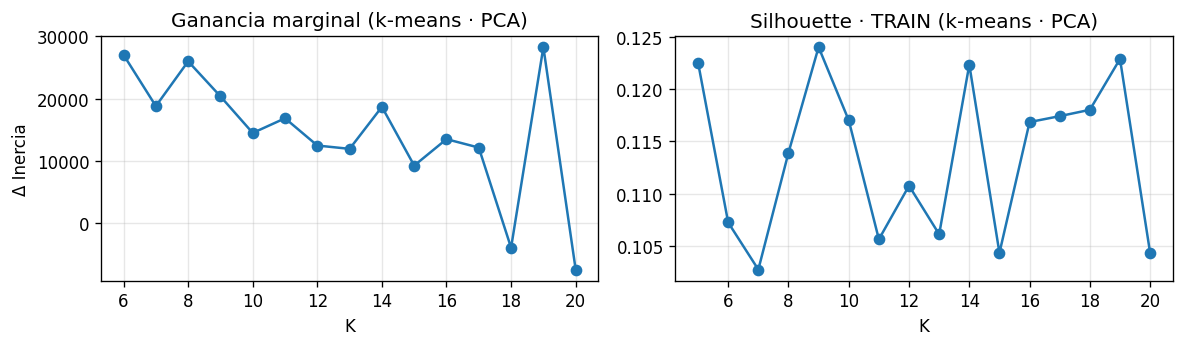

[Selección por ELBOW] umbral: 6 | 2da dif: 20 | (Silhouette TRAIN máx: 9)


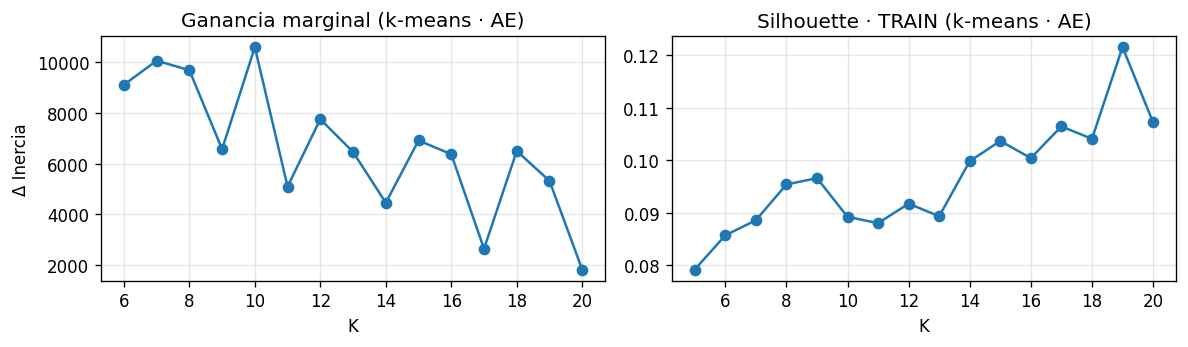

[Selección por ELBOW] umbral: 6 | 2da dif: 11 | (Silhouette TRAIN máx: 19)
K finales k-means | PCA: 6  | AE: 6


In [39]:

Ks = range(5, 21)

def _silhouette_safe_train(Z, labels, fill=0.0):
    """
    Silhouette en TRAIN ignorando clusters con 1 muestra.
    Si tras filtrar no quedan al menos 2 clusters con >=2 muestras, devuelve `fill` (0.0).
    """
    labels = np.asarray(labels)
    u, c = np.unique(labels, return_counts=True)
    if u.size < 2:
        return float(fill)
    keep_clusters = u[c >= 2]
    keep = np.isin(labels, keep_clusters)
    if keep.sum() < 2 or np.unique(labels[keep]).size < 2:
        return float(fill)
    return float(metrics.silhouette_score(Z[keep], labels[keep]))

def kmeans_sweep_train_only(Ztr, Ks, seed=RNG_SEED):
    inertias, sil_tr = [], []
    for K in Ks:
        km = models.KMeans(n_clusters=K, n_init=8, random_state=seed).fit(Ztr)
        inertias.append(km.inertia_)
        sil_tr.append(_silhouette_safe_train(Ztr, km.labels_, fill=0.0))
    return np.array(inertias), np.array(sil_tr)

# PCA
in_km_pca, siltr_km_pca = kmeans_sweep_train_only(Ztr_pca, Ks)
silva_km_pca = np.full(len(list(Ks)), np.nan)  # placeholder para compatibilidad

# AE
in_km_ae,  siltr_km_ae  = kmeans_sweep_train_only(z_tr, Ks)
silva_km_ae  = np.full(len(list(Ks)), np.nan)  # placeholder para compatibilidad

def plot_kmeans_selection_trainonly(Ks, inertia, sil_tr, title_suffix=""):
    gains = metrics.elbow_gains(inertia)
    Ks = list(Ks)
    fig, ax = plt.subplots(1,2, figsize=(10,3))
    ax[0].plot(Ks, gains, marker="o"); ax[0].set_title(f"Ganancia marginal {title_suffix}")
    ax[0].set_xlabel("K"); ax[0].set_ylabel("Δ Inercia"); ax[0].grid(True, alpha=0.3)
    ax[1].plot(Ks, sil_tr, marker="o"); ax[1].set_title(f"Silhouette · TRAIN {title_suffix}")
    ax[1].set_xlabel("K"); ax[1].grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    k_rel, k_dd, _ = metrics.select_k_by_elbow(inertia, Ks, rel_thresh=0.05)
    k_sil_train = Ks[int(np.nanargmax(sil_tr))]
    print(f"[Selección por ELBOW] umbral: {k_rel} | 2da dif: {k_dd} | (Silhouette TRAIN máx: {k_sil_train})")
    return k_rel, k_dd, k_sil_train

# Plots + selección
krel_p, kdd_p, ksiltr_p = plot_kmeans_selection_trainonly(Ks, in_km_pca, siltr_km_pca, "(k-means · PCA)")
krel_a, kdd_a, ksiltr_a = plot_kmeans_selection_trainonly(Ks, in_km_ae,  siltr_km_ae,  "(k-means · AE)")

# Elección FINAL de K para k-means: solo ELBOW (conservador)
K_km_pca = int(min(krel_p, kdd_p))
K_km_ae  = int(min(krel_a, kdd_a))
print("K finales k-means | PCA:", K_km_pca, " | AE:", K_km_ae)



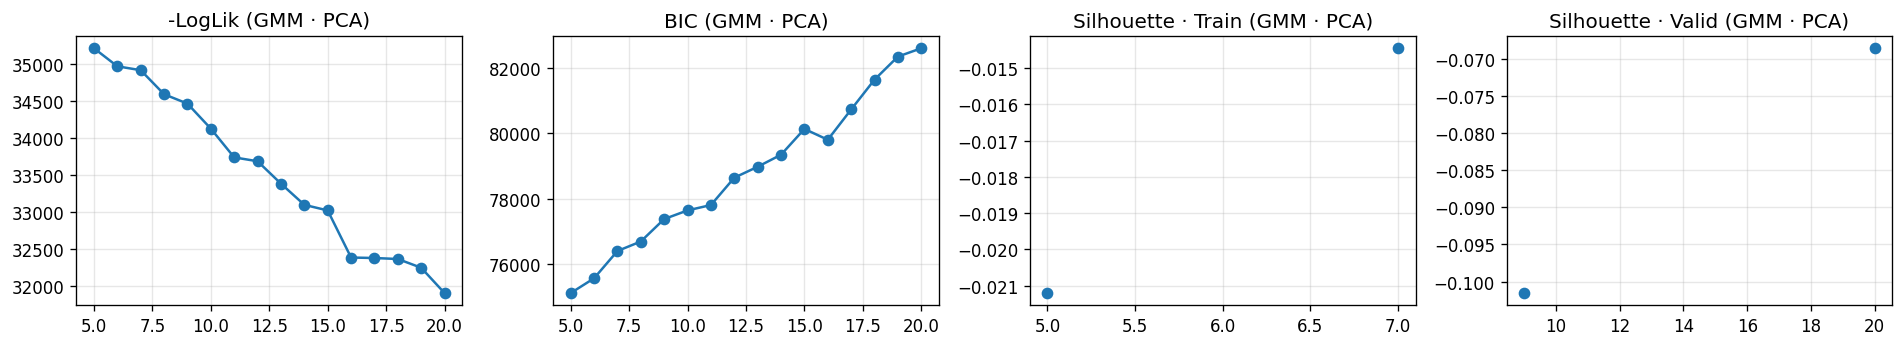

K por BIC: 5 | K por Silhouette VALID: 20


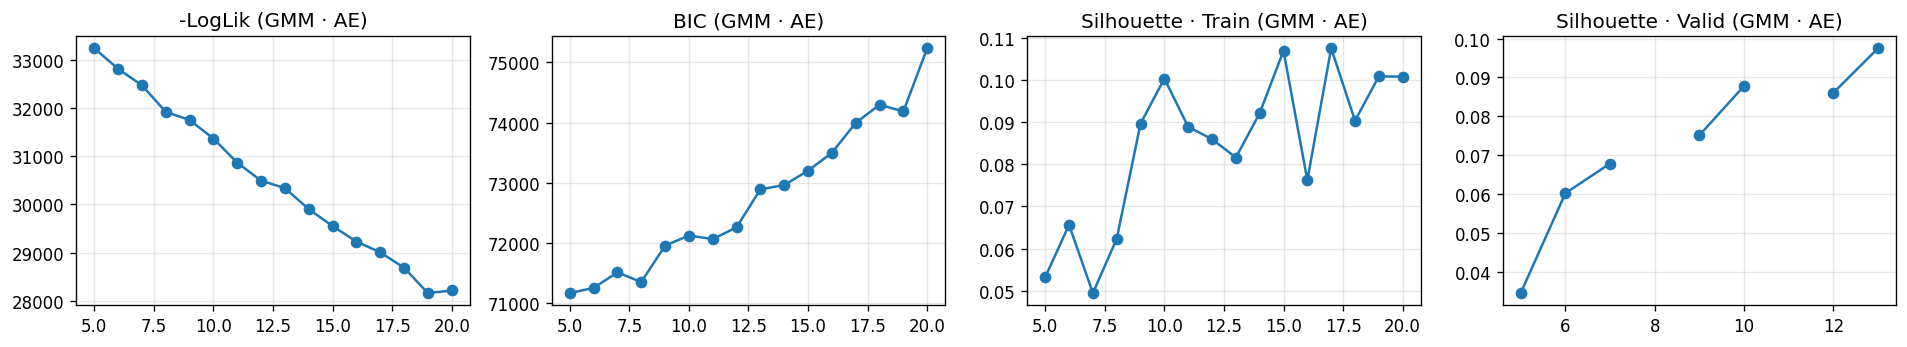

K por BIC: 5 | K por Silhouette VALID: 13
K finales GMM | PCA: 20 | AE: 13


In [40]:
# ===== Celda 6 — Barridos de K en GMM (fit en train, eval train+valid) =====
def gmm_sweep_train_val(Ztr, Zval, Ks, n_init=10, reg=1e-2, cov="diag", seed=RNG_SEED):
    # estandarizamos (fit en train)
    st = pre.zstd_fit(Ztr)
    Ztr_g = pre.zstd_transform(Ztr, st)
    Zval_g = pre.zstd_transform(Zval, st)

    logliks, bics, sil_tr, sil_val = [], [], [], []
    N, D = Ztr_g.shape
    for K in Ks:
        # múltiples reinicios con k-means init en el primero
        best_ll = -np.inf; best_model = None
        km_init = models.KMeans(n_clusters=K, n_init=5, random_state=seed).fit(Ztr_g).cluster_centers_
        inits = [km_init]
        rng = np.random.default_rng(seed)
        for _ in range(n_init-1):
            idx = rng.choice(N, size=K, replace=False)
            inits.append(Ztr_g[idx].copy())

        for init in inits:
            gmm = models.GMM(n_components=K, reg_covar=reg, random_state=seed, init_means=init, cov_type=cov).fit(Ztr_g)
            if gmm.loglik_ > best_ll:
                best_ll = gmm.loglik_; best_model = gmm

        p = metrics.gmm_num_params(D, K, cov_type=cov)
        bic = -2*best_ll + p*np.log(N)

        labs_tr  = best_model.predict(Ztr_g)
        labs_val = best_model.predict(Zval_g)

        # silhouette robusto (NaN si hay singletons)
        uniq_tr, cnt_tr = np.unique(labs_tr, return_counts=True)
        uniq_va, cnt_va = np.unique(labs_val, return_counts=True)
        sil_tr_k  = np.nan if (len(uniq_tr)<2 or (cnt_tr<2).any()) else metrics.silhouette_score(Ztr_g,  labs_tr)
        sil_val_k = np.nan if (len(uniq_va)<2 or (cnt_va<2).any()) else metrics.silhouette_score(Zval_g, labs_val)

        logliks.append(best_ll); bics.append(bic); sil_tr.append(sil_tr_k); sil_val.append(sil_val_k)

    return (np.array(logliks), np.array(bics), np.array(sil_tr), np.array(sil_val))

# PCA
ll_p, bic_p, siltr_gmm_p, silva_gmm_p = gmm_sweep_train_val(Ztr_pca, Zval_pca, Ks, n_init=10, reg=1e-2, cov="diag")
# AE
ll_a, bic_a, siltr_gmm_a, silva_gmm_a = gmm_sweep_train_val(z_tr,    z_val,    Ks, n_init=10, reg=1e-2, cov="diag")

def plot_gmm_selection(Ks, ll, bic, sil_tr, sil_val, title_suffix=""):
    Ks = list(Ks)
    fig, ax = plt.subplots(1,4, figsize=(16,3))
    ax[0].plot(Ks, -ll,  marker="o"); ax[0].set_title(f"-LogLik {title_suffix}"); ax[0].grid(True, alpha=0.3)
    ax[1].plot(Ks, bic, marker="o"); ax[1].set_title(f"BIC {title_suffix}");     ax[1].grid(True, alpha=0.3)
    ax[2].plot(Ks, sil_tr, marker="o"); ax[2].set_title(f"Silhouette · Train {title_suffix}"); ax[2].grid(True, alpha=0.3)
    ax[3].plot(Ks, sil_val, marker="o"); ax[3].set_title(f"Silhouette · Valid {title_suffix}"); ax[3].grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()
    k_bic  = Ks[int(np.argmin(bic))]
    k_silv = Ks[int(np.nanargmax(sil_val))] if np.isfinite(np.nanmax(sil_val)) else None
    print(f"K por BIC: {k_bic} | K por Silhouette VALID: {k_silv}")
    return k_bic, k_silv

k_bic_p, k_silv_p = plot_gmm_selection(Ks, ll_p, bic_p, siltr_gmm_p, silva_gmm_p, "(GMM · PCA)")
k_bic_a, k_silv_a = plot_gmm_selection(Ks, ll_a, bic_a, siltr_gmm_a, silva_gmm_a, "(GMM · AE)")

# elección final de K para GMM: preferimos Silhouette VALID, respaldo por BIC
K_gmm_pca = int(k_silv_p) if k_silv_p is not None else int(k_bic_p)
K_gmm_ae  = int(k_silv_a) if k_silv_a is not None else int(k_bic_a)
print("K finales GMM | PCA:", K_gmm_pca, "| AE:", K_gmm_ae)


In [41]:
# ===== Selección de dos modelos: mejor KMEANS y mejor GMM =====
Ks_list = list(Ks)

# --- helpers ---
def _silhouette_safe_train(Z, labels):
    u, c = np.unique(labels, return_counts=True)
    if len(u) < 2 or (c < 2).any(): 
        return 0.0
    return float(metrics.silhouette_score(Z, labels))

def fit_kmeans_final(rep: str, K: int):
    if rep == "pca":
        Ztr, Zval = Ztr_pca, Zval_pca
    else:
        Ztr, Zval = z_tr, z_val
    km = models.KMeans(n_clusters=K, n_init=10, random_state=RNG_SEED).fit(Ztr)
    sil_tr = _silhouette_safe_train(Ztr, km.labels_)
    labs_tr = km.labels_
    labs_val = km.predict(Zval)
    return {"rep":rep, "K":K, "model":km, "sil_train":sil_tr,
            "labels_train":labs_tr, "labels_valid":labs_val}

def fit_gmm_final(rep: str, K: int):
    if rep == "pca":
        Ztr, Zval = Ztr_pca, Zval_pca
        bic_vec, silv_vec = bic_p, silva_gmm_p
    else:
        Ztr, Zval = z_tr, z_val
        bic_vec, silv_vec = bic_a, silva_gmm_a

    st_lat = pre.zstd_fit(Ztr)
    Ztr_g  = pre.zstd_transform(Ztr,  st_lat)
    Zval_g = pre.zstd_transform(Zval, st_lat)

    init = models.KMeans(n_clusters=K, n_init=5, random_state=RNG_SEED).fit(Ztr_g).cluster_centers_
    gmm  = models.GMM(n_components=K, reg_covar=1e-2, random_state=RNG_SEED,
                      init_means=init, cov_type="diag").fit(Ztr_g)
    labs_tr  = gmm.predict(Ztr_g)
    labs_val = gmm.predict(Zval_g)

    sil_tr = _silhouette_safe_train(Ztr_g, labs_tr)
    # validar por silhouette VALID si está disponible, si no queda NaN
    try:
        idxK = Ks_list.index(K)
        sil_v = float(silv_vec[idxK]) if np.isfinite(silv_vec[idxK]) else np.nan
        bic_K = float(bic_vec[idxK])
    except Exception:
        sil_v = np.nan
        bic_K = np.inf

    return {"rep":rep, "K":K, "model":gmm, "st_lat":st_lat,
            "sil_train":sil_tr, "sil_valid":sil_v, "bic":bic_K,
            "labels_train":labs_tr, "labels_valid":labs_val}

# --- KMEANS: elegimos entre PCA y AE por silhouette TRAIN (no usamos VALID) ---
km_candidate_p = fit_kmeans_final("pca", K_km_pca)
km_candidate_a = fit_kmeans_final("ae",  K_km_ae)
best_kmeans = max([km_candidate_p, km_candidate_a], key=lambda d: d["sil_train"])
print(f"[KMEANS] rep={best_kmeans['rep']} | K={best_kmeans['K']} | silhouette TRAIN={best_kmeans['sil_train']:.4f}")

# --- GMM: preferimos silhouette VALID; si no hay, menor BIC; si empata, mayor silhouette TRAIN ---
gmm_candidate_p = fit_gmm_final("pca", K_gmm_pca)
gmm_candidate_a = fit_gmm_final("ae",  K_gmm_ae)

def gmm_rank(c):
    # mayor es mejor: primero sil_valid (NaN -> -inf), luego -bic, luego sil_train
    silv = c["sil_valid"]; silv = -np.inf if not np.isfinite(silv) else silv
    return (silv, -c["bic"], c["sil_train"])

best_gmm = max([gmm_candidate_p, gmm_candidate_a], key=gmm_rank)
print(f"[GMM] rep={best_gmm['rep']} | K={best_gmm['K']} | sil_VALID={best_gmm['sil_valid']} | BIC={best_gmm['bic']:.1f} | sil_TRAIN={best_gmm['sil_train']:.4f}")


[KMEANS] rep=pca | K=6 | silhouette TRAIN=0.1072
[GMM] rep=ae | K=13 | sil_VALID=0.09751270579072298 | BIC=72892.3 | sil_TRAIN=0.0816


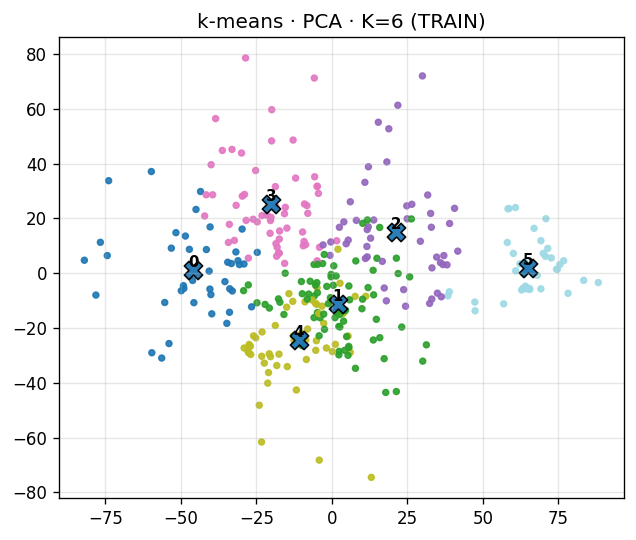

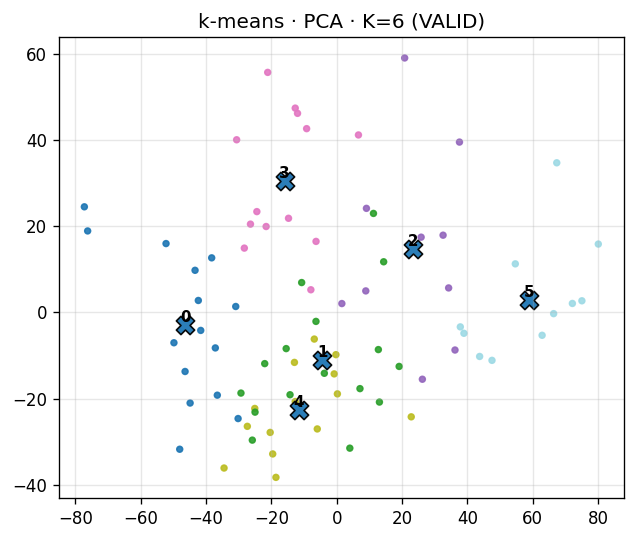

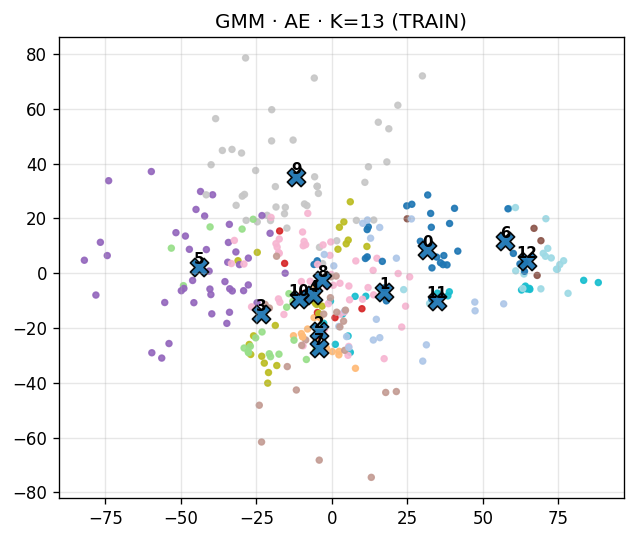

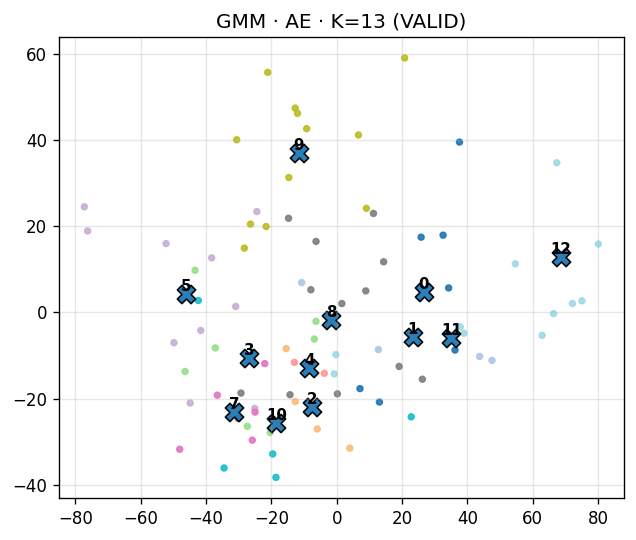

In [42]:
# ===== Plots 2D para KMEANS y GMM elegidos =====
# PCA SOLO para visualización (fit en TRAIN)
pca_vis = pre.pca_fit(Xtr_std)
Z2_tr   = pre.pca_transform(Xtr_std,  pca_vis, k=2)
Z2_val  = pre.pca_transform(Xval_std, pca_vis, k=2)

def _plot_clusters_2d(Z2, labels, title):
    labels = np.asarray(labels)
    uniq = np.unique(labels); K = uniq.size
    cmap = plt.get_cmap("tab20", K)
    fig, ax = plt.subplots(figsize=(5.4,4.6))
    sc = ax.scatter(Z2[:,0], Z2[:,1], c=labels, s=12, cmap=cmap, vmin=uniq.min(), vmax=uniq.max(), alpha=0.9)
    ax.set_title(title); ax.grid(True, alpha=0.3)
    # centroides en el plano 2D de visualización
    cents = np.vstack([Z2[labels==k].mean(0) for k in uniq])
    ax.scatter(cents[:,0], cents[:,1], marker="X", s=120, edgecolor="k", linewidths=1.0, alpha=0.95, label="Centroides")
    for k,(cx,cy) in zip(uniq, cents):
        ax.text(cx, cy, str(int(k)), ha="center", va="bottom", fontsize=9, weight="bold")
    plt.tight_layout(); plt.show()

# --- k-means elegido ---
km_labs_tr  = best_kmeans["labels_train"]
km_labs_val = best_kmeans["labels_valid"]
_plot_clusters_2d(Z2_tr,  km_labs_tr,  f"k-means · {best_kmeans['rep'].upper()} · K={best_kmeans['K']} (TRAIN)")
_plot_clusters_2d(Z2_val, km_labs_val, f"k-means · {best_kmeans['rep'].upper()} · K={best_kmeans['K']} (VALID)")

# --- GMM elegido ---
gm_labs_tr  = best_gmm["labels_train"]
gm_labs_val = best_gmm["labels_valid"]
_plot_clusters_2d(Z2_tr,  gm_labs_tr,  f"GMM · {best_gmm['rep'].upper()} · K={best_gmm['K']} (TRAIN)")
_plot_clusters_2d(Z2_val, gm_labs_val, f"GMM · {best_gmm['rep'].upper()} · K={best_gmm['K']} (VALID)")
  

In [43]:
# Usa la representación que estés probando con GMM (ej. PCA)
Ztr_rep, Zval_rep = Ztr_pca, Zval_pca  # o z_tr, z_val si querés diagnosticar AE

# Estándar GMM (lo que venías usando):
st_lat = pre.zstd_fit(Ztr_rep)
Ztr_g  = pre.zstd_transform(Ztr_rep, st_lat)

init = models.KMeans(n_clusters=K_gmm_pca, n_init=10, random_state=RNG_SEED).fit(Ztr_g).cluster_centers_
gmm  = models.GMM(n_components=K_gmm_pca, reg_covar=1e-2, random_state=RNG_SEED,
                  init_means=init, cov_type="diag").fit(Ztr_g)

R = gmm.predict_proba(Ztr_g)  # responsabilidades
Nk = R.sum(0)
H = -(R * (np.log(R + 1e-12))).sum(1) / np.log(gmm.K)  # entropía normalizada por muestra
print("Nk (tamaño efectivo por componente):", np.round(Nk,1))
print("Entropía media de responsabilidades (0=asignación dura, 1=uniforme):", float(H.mean()))

# Si ves:
# - Nk muy desparejos (algunos ~0): componentes colapsados (mala init / poca regularización).
# - H ~ 1: el modelo no “se decide” (responsabilidades planas).


Nk (tamaño efectivo por componente): [10.   5.   8.   3.   3.   8.   8.   2.   7.  15.   7.   3.  49.1 12.   5.  75.1 16.   8.   8.  67.8]
Entropía media de responsabilidades (0=asignación dura, 1=uniforme): 0.0039018802892145862
